In [1]:
from pandas_datareader import data as pdr
import yfinance as yf
import ta
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import missingno as msno 
import seaborn as sns

In [2]:
%run functions.py

# Load Sentiment data from local file 

In [3]:
sentiment_score = pd.read_csv('data/Sentiment_score.csv',index_col=0)

sentiment_score['Date'] = pd.to_datetime(sentiment_score['Date'])
sentiment_score=sentiment_score.rename(columns={
    'Value': 'sentiment_score'})

In [4]:
sentiment_score.head()

,sentiment_score,Date
0,0.1250,2017-03-02
1,-0.0090,2017-03-03
2,-0.3832,2017-03-04
3,0.1771,2017-03-05
4,-0.1986,2017-03-06


In [5]:
sentiment_score.tail()

,sentiment_score,Date
2459,-0.2926,2023-11-25
2460,-0.3004,2023-11-26
2461,-0.1801,2023-11-27
2462,0.1895,2023-11-28
2463,-0.1800,2023-11-29


# Fetch Data (btc, gold, oil, s&p500) & merge with sentiment data

In [6]:
start    =sentiment_score.Date.min()
end      =sentiment_score.Date.max()

# Bitcoin data
data_btc = fetch_data('BTC-USD', start, end)
data_btc = data_btc.rename(columns=lambda x: x + '_btc')

# Gold data
data_gold = fetch_data('GC=F', start, end)
data_gold = data_gold.rename(columns=lambda x: x + '_gold')

# Oil data
data_oil = fetch_data('CL=F', start, end)
data_oil = data_oil.rename(columns=lambda x: x + '_oil')

#SP500 Data

data_sp500 = fetch_data('^GSPC', start, end)
data_sp500 = data_sp500.rename(columns=lambda x: x + '_sp500')

# Merging datasets
data = pd.merge(data_btc.reset_index(), data_gold.reset_index(), on='Date', how='left')
data = pd.merge(data, data_oil.reset_index(), on='Date', how='left')
data = pd.merge(data, data_sp500.reset_index(), on='Date', how='left')
data = pd.merge(data, sentiment_score.reset_index(), on='Date', how='left')

data = data.set_index('index')


#data.to_csv('data/btc_gold_oil_sp500_sentiment.csv')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


<Axes: >

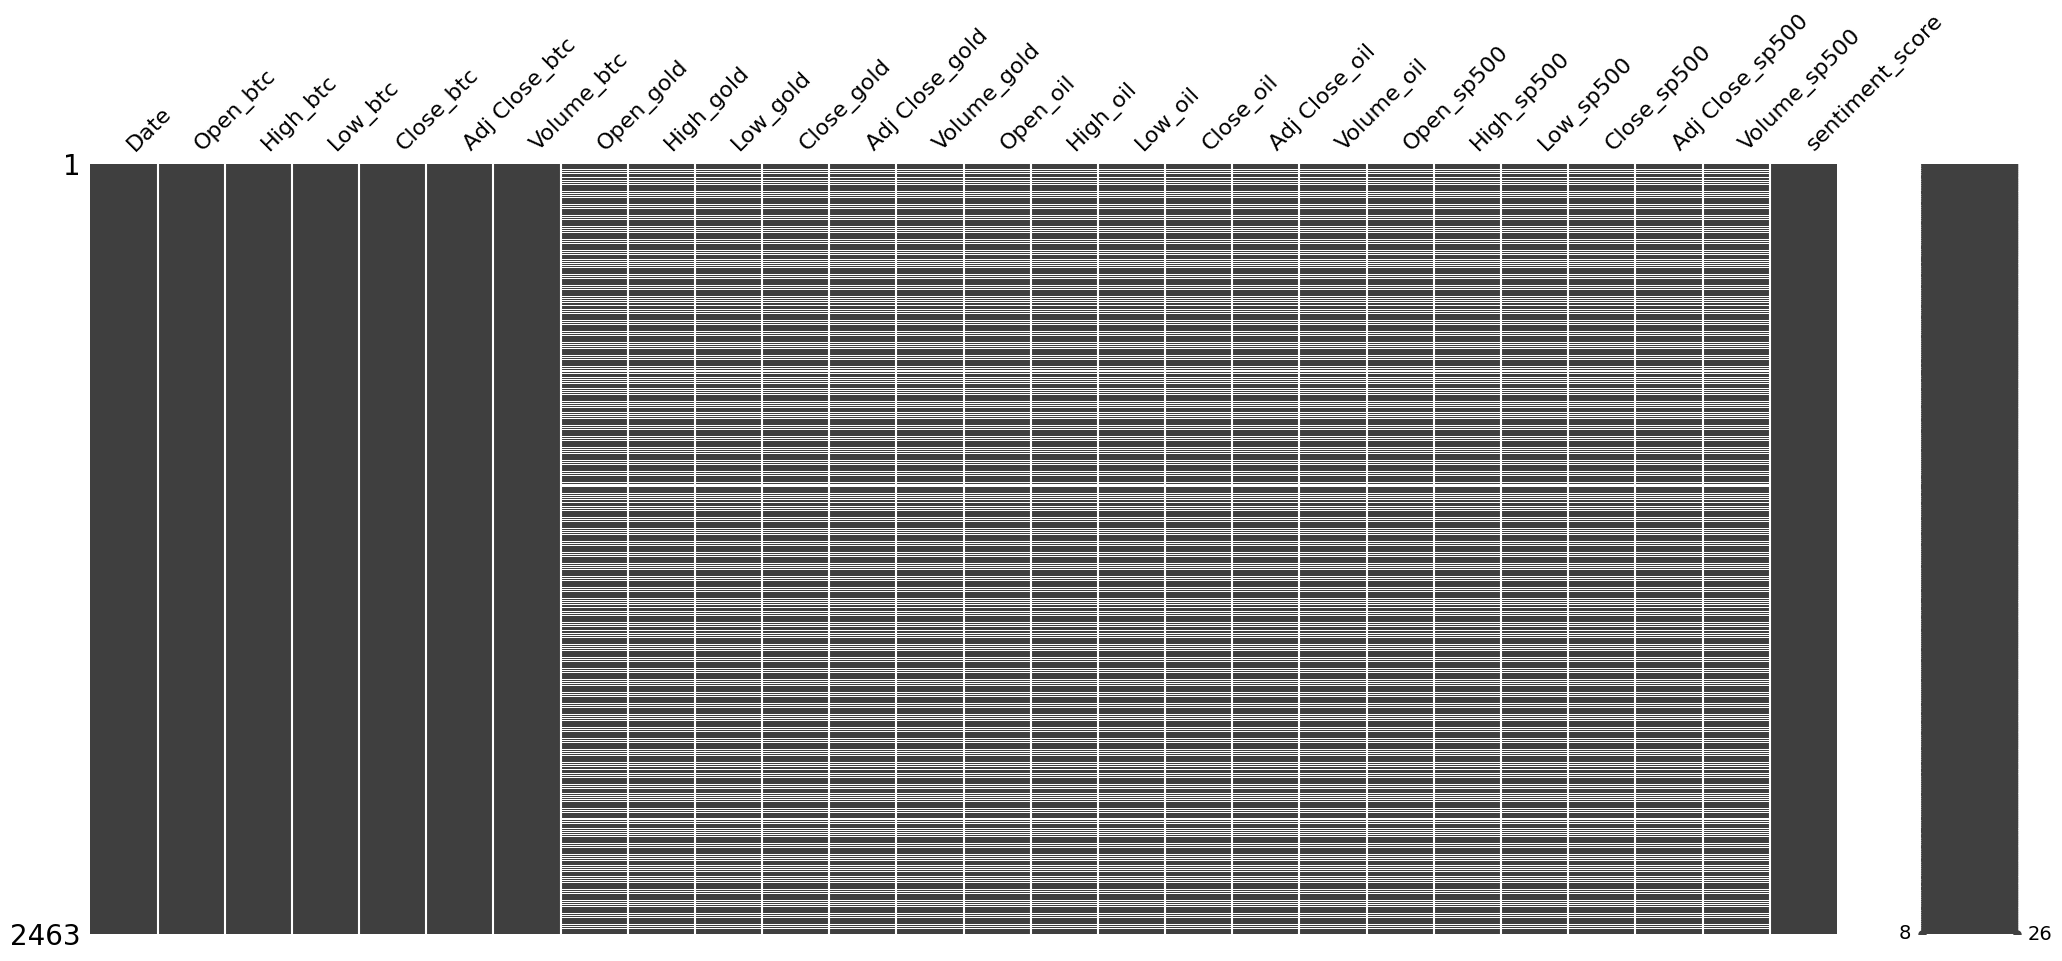

In [7]:
msno.matrix(data)

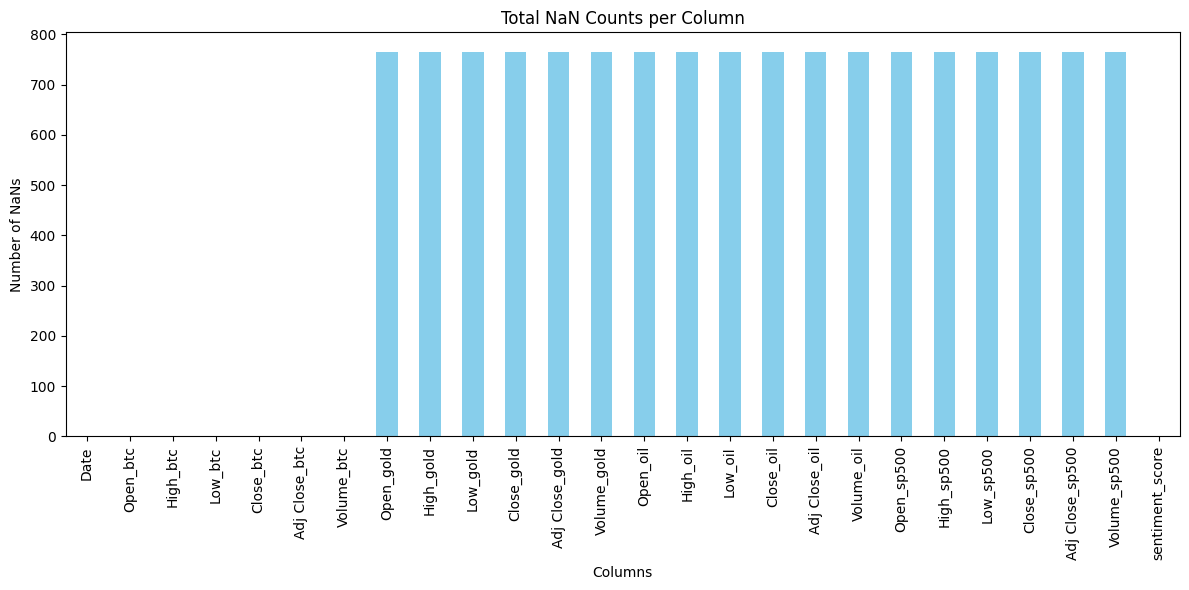

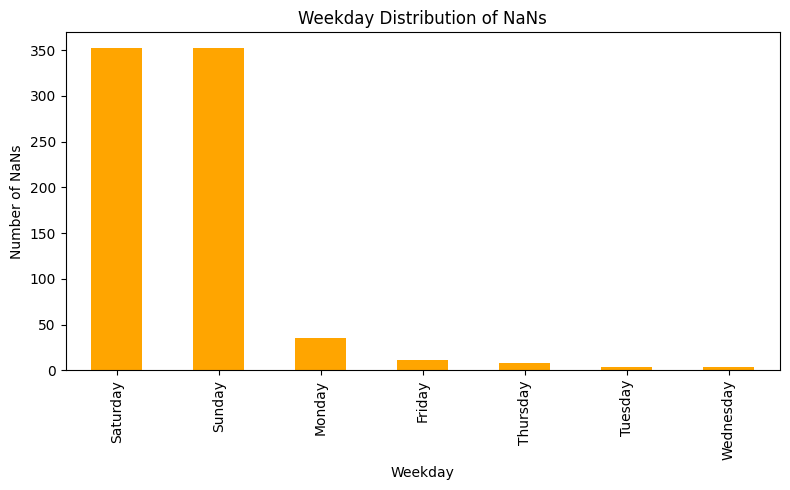

In [8]:
nan_counts, nan_weekday_counts = visualize_nans(data, date_column='Date')


In [9]:
# make forwardfill

data_aug = data.ffill()

<Axes: >

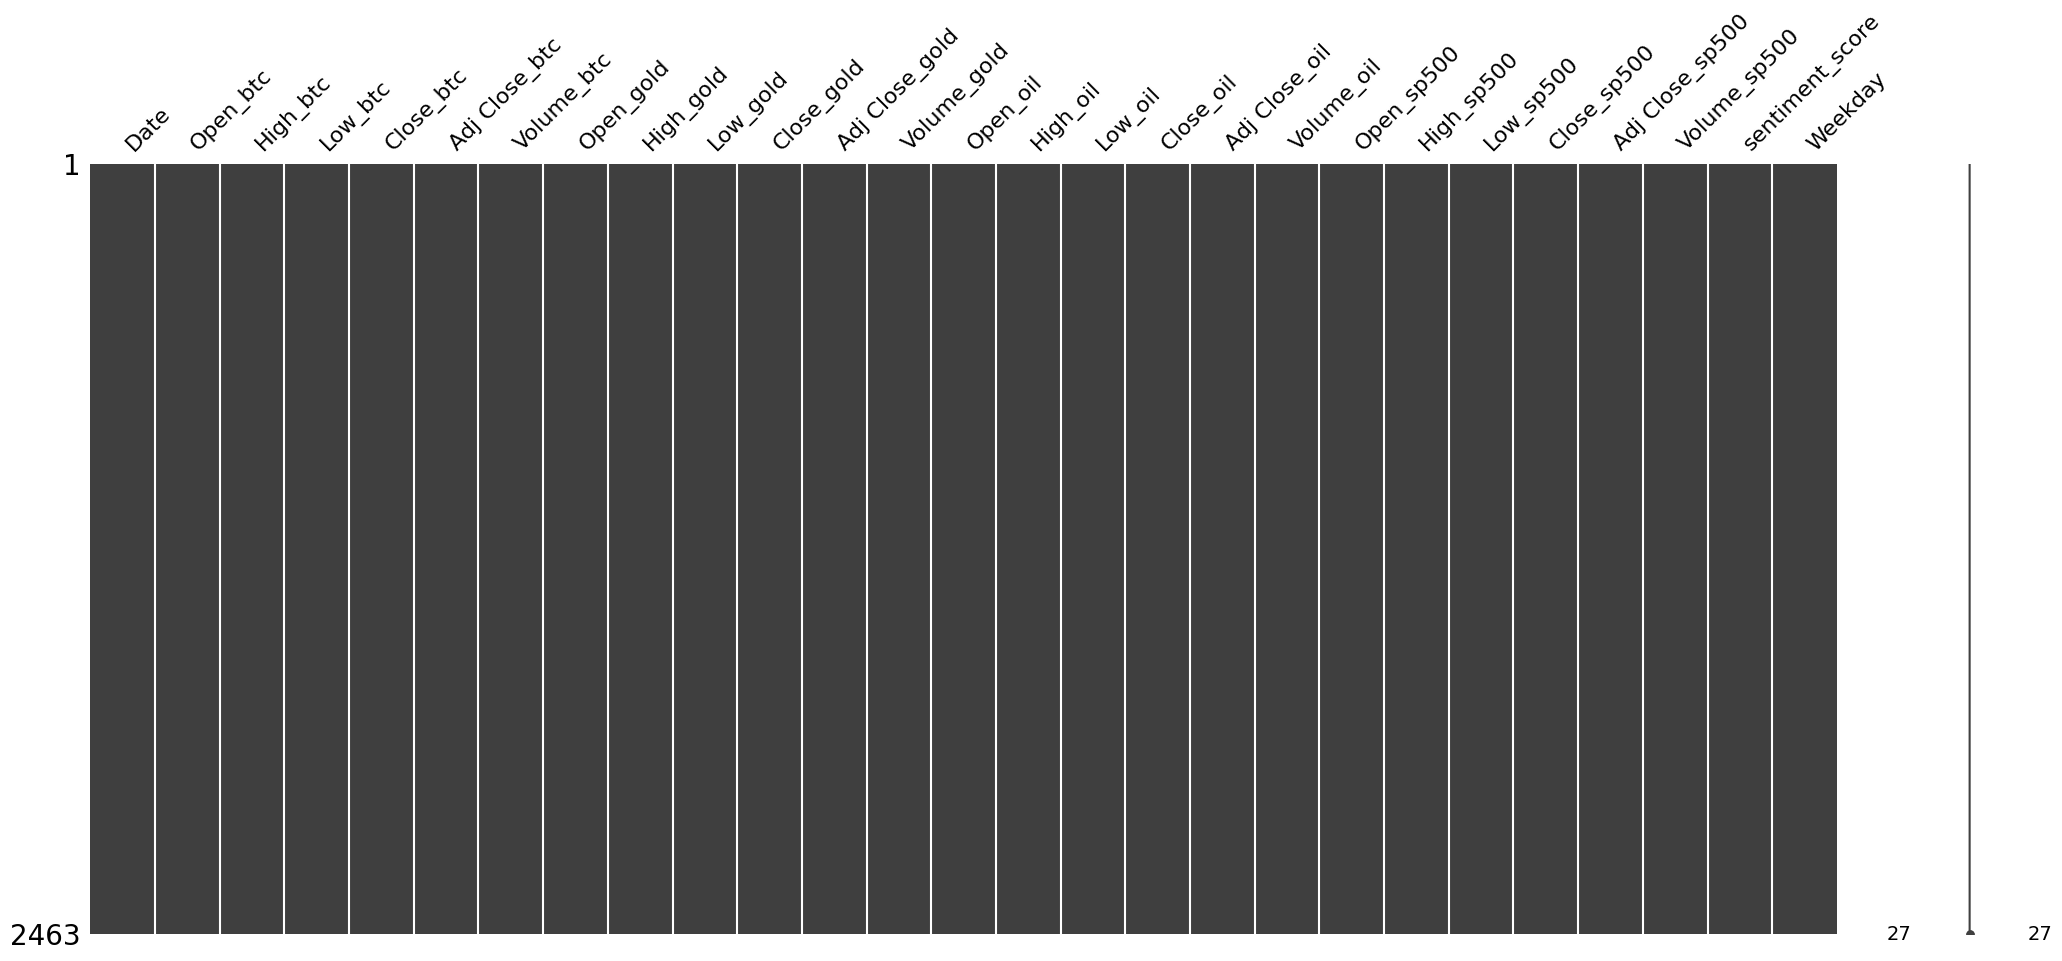

In [10]:
msno.matrix(data_aug)

In [11]:
data_aug.to_csv('data/btc_gold_oil_sp500_sentiment_clean.csv')

In [12]:
%run functions.py

# Do Some Feature Enigneering 

In [13]:
target   = 'target_class' 
target2   = 'target_value' 
variable = 'Close_btc'

In [14]:
data_aug = add_target_column(data_aug,target,target2,variable)


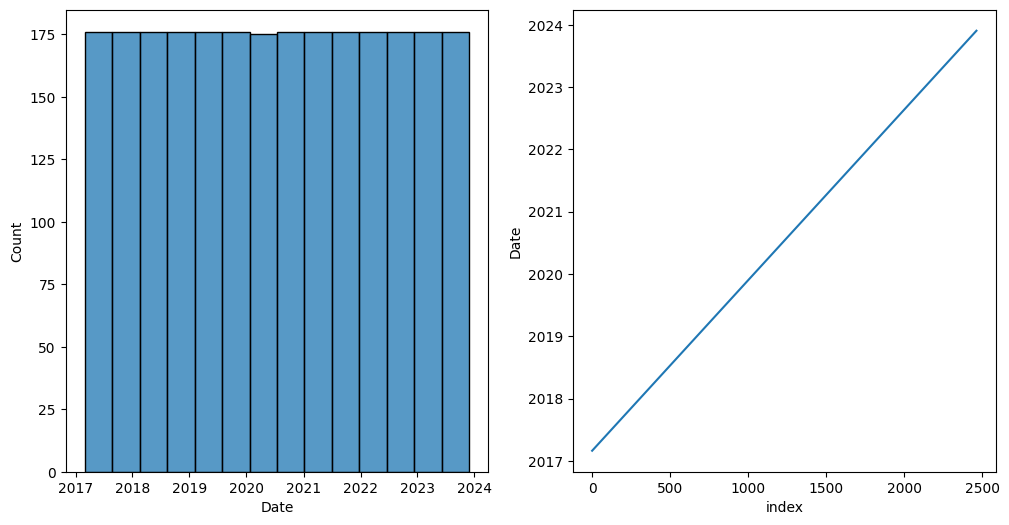

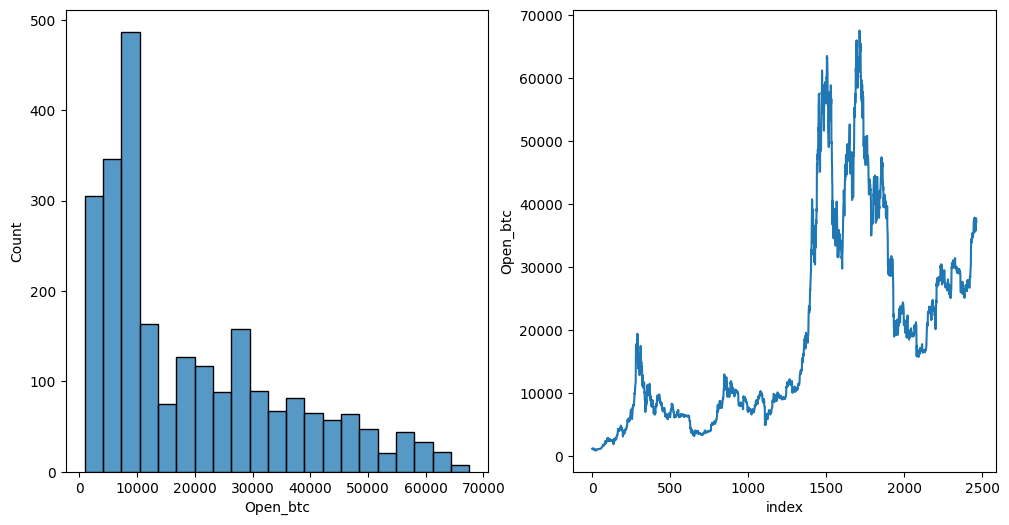

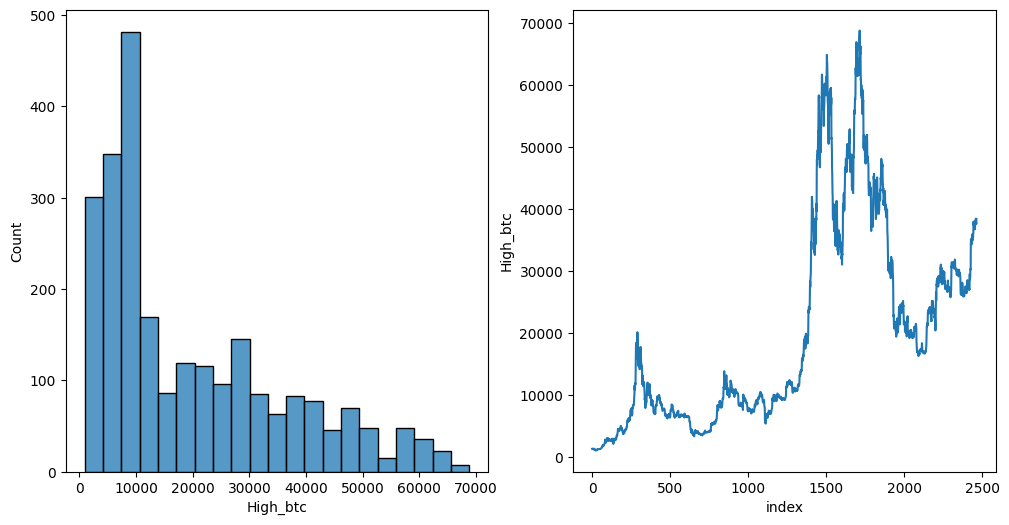

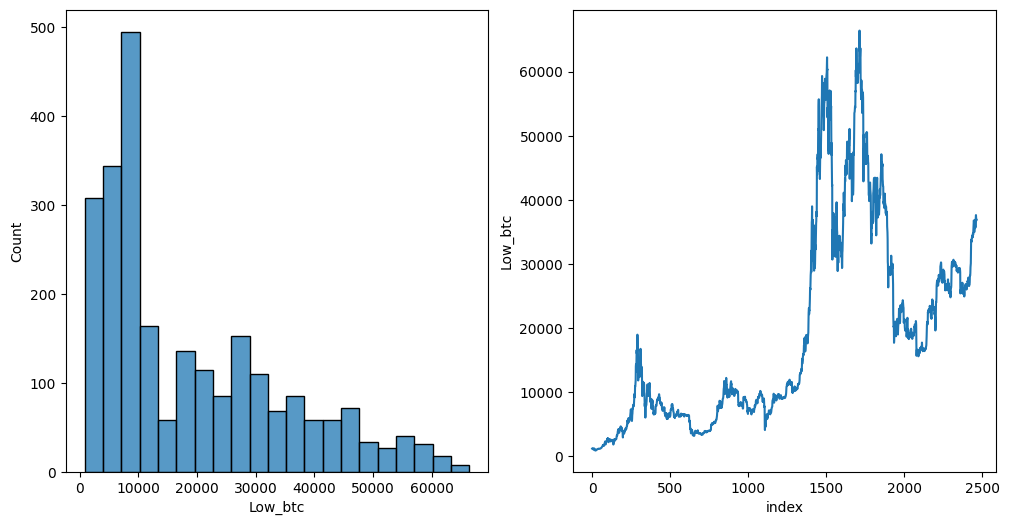

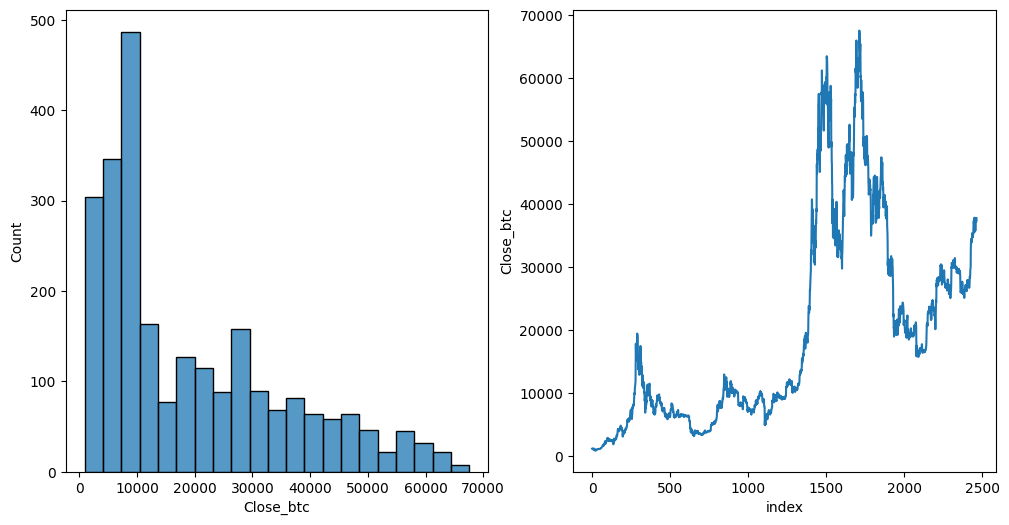

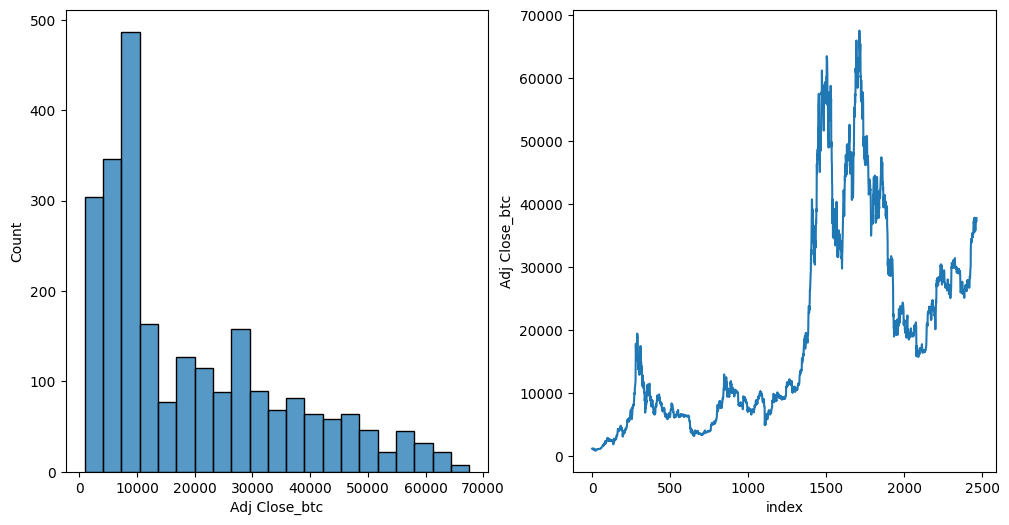

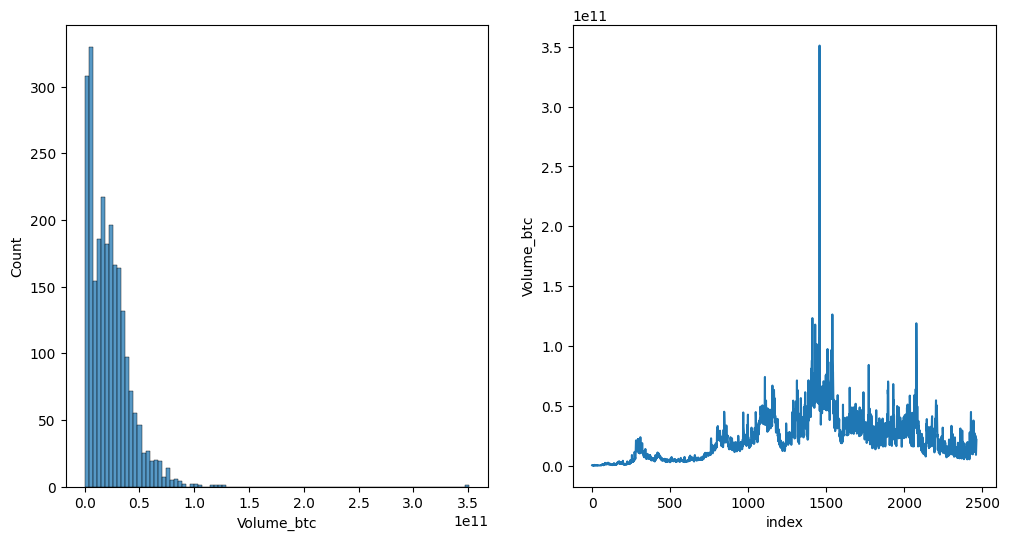

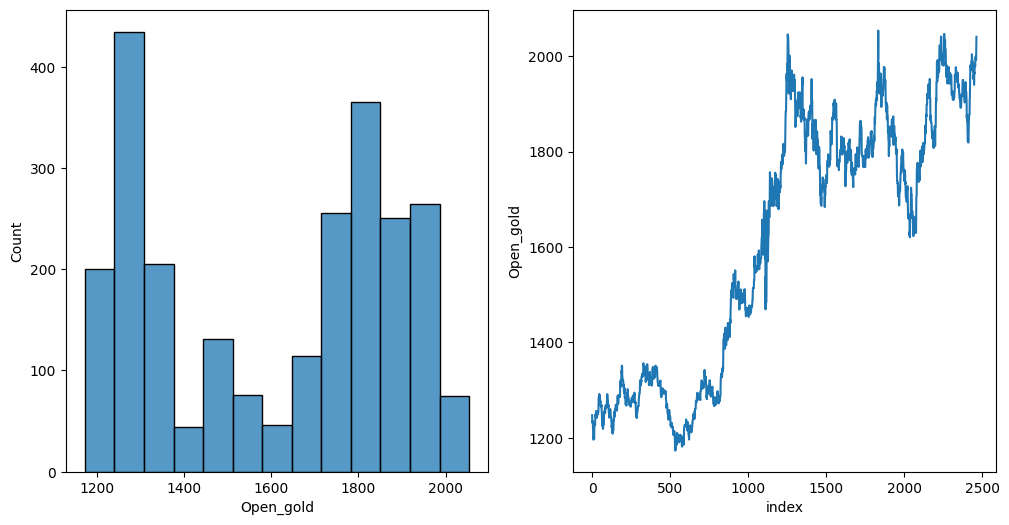

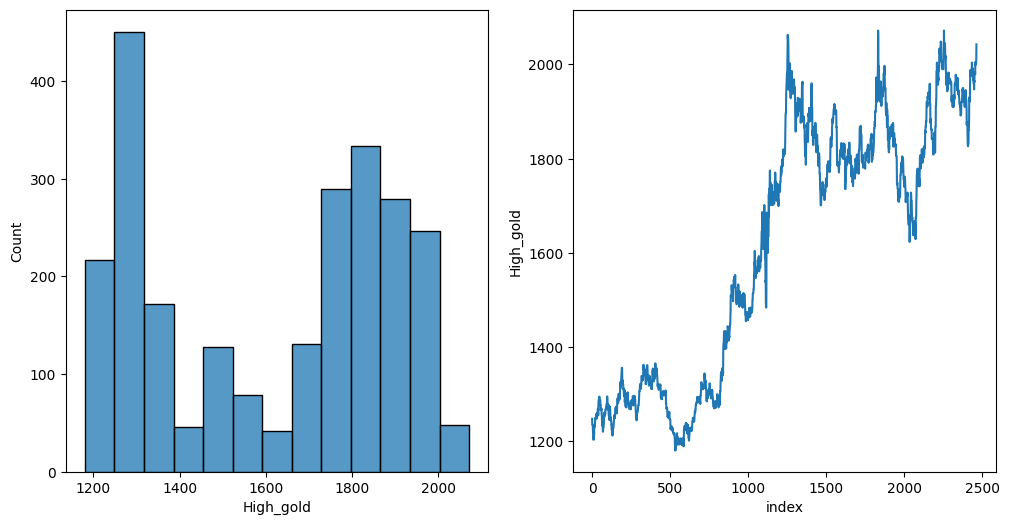

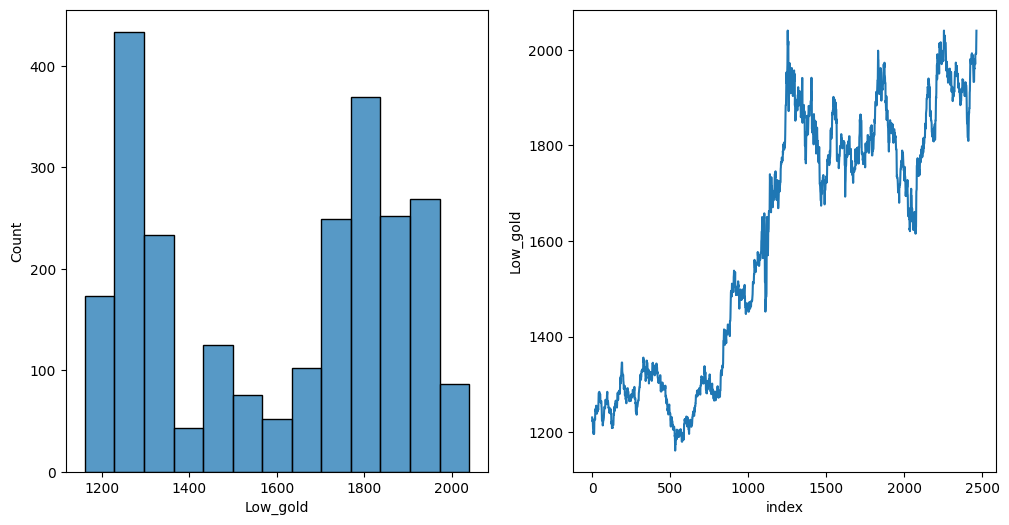

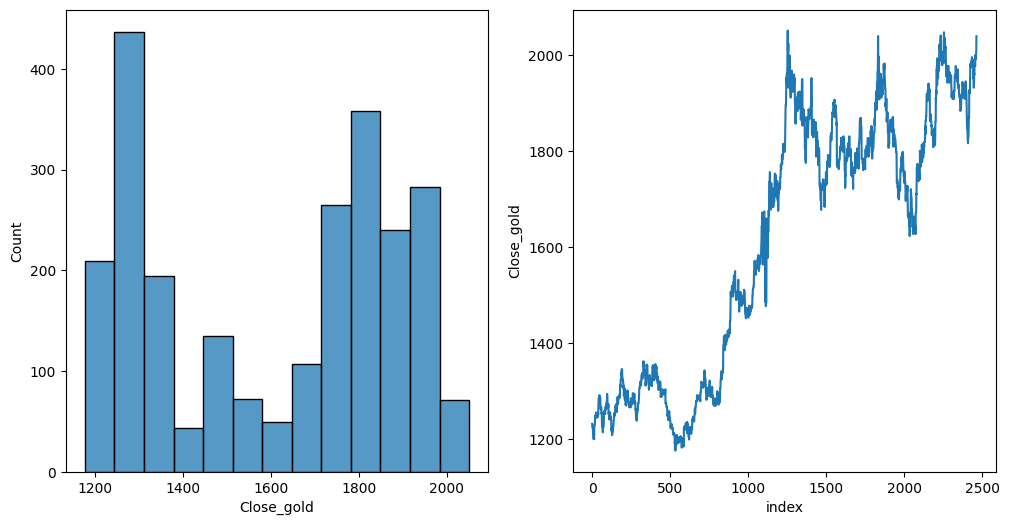

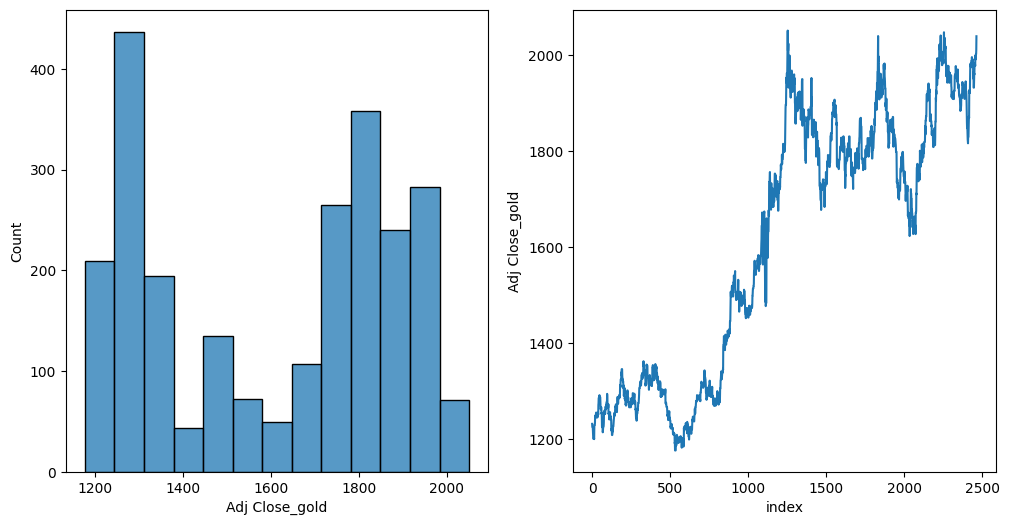

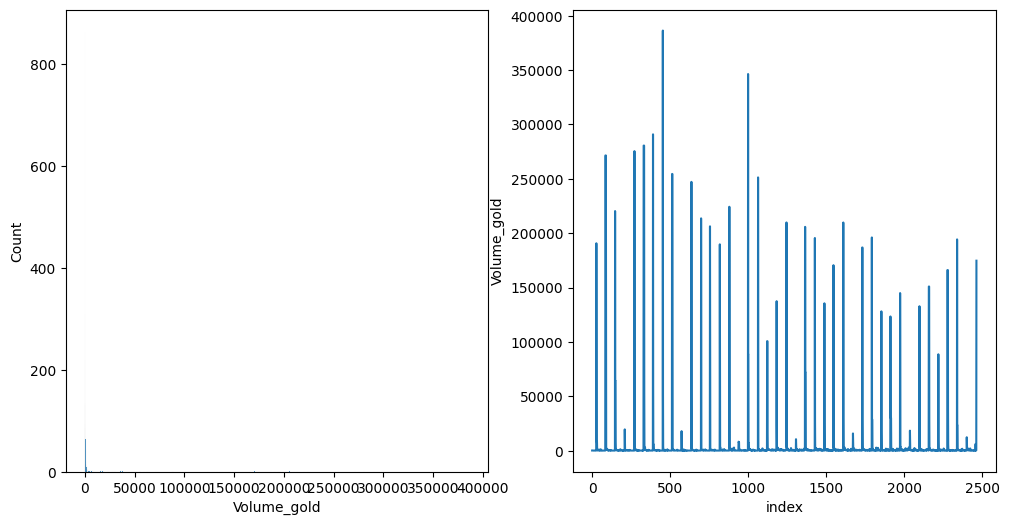

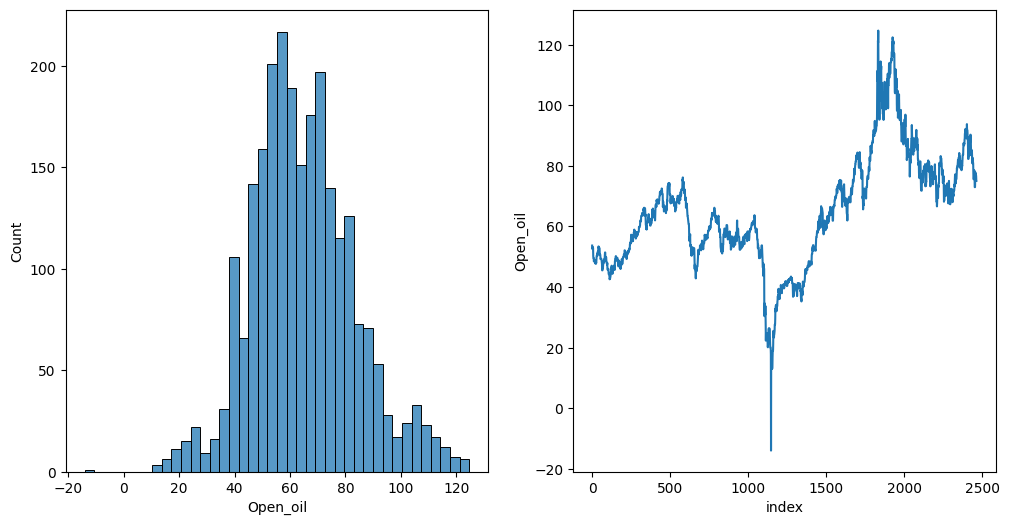

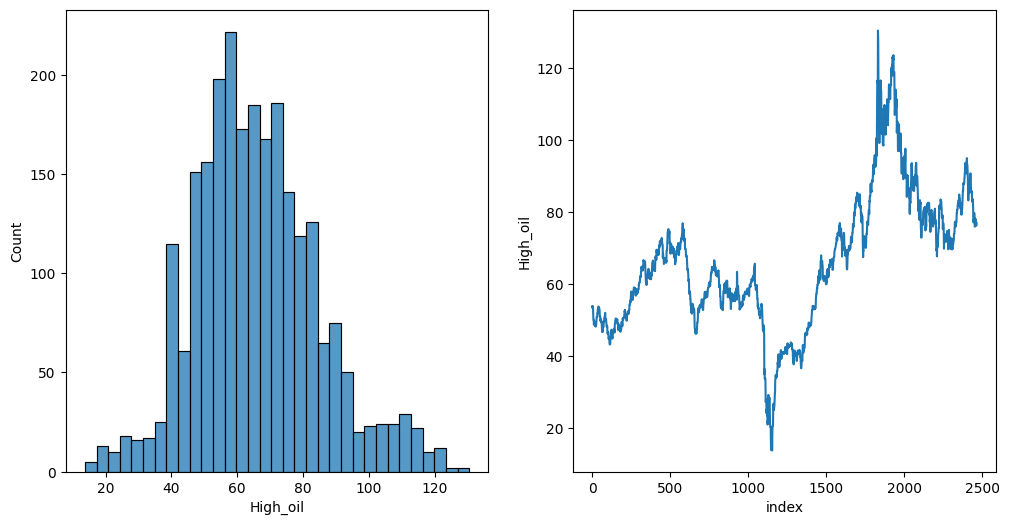

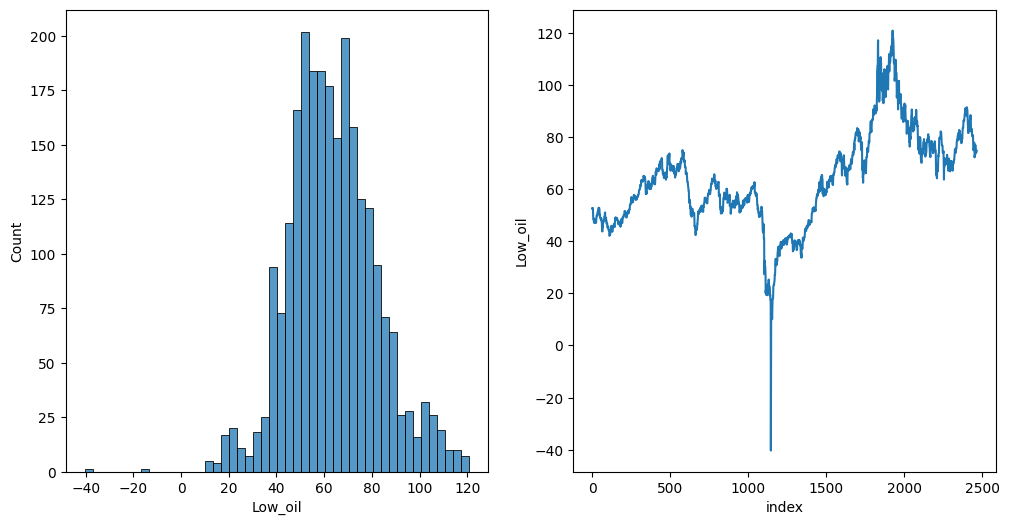

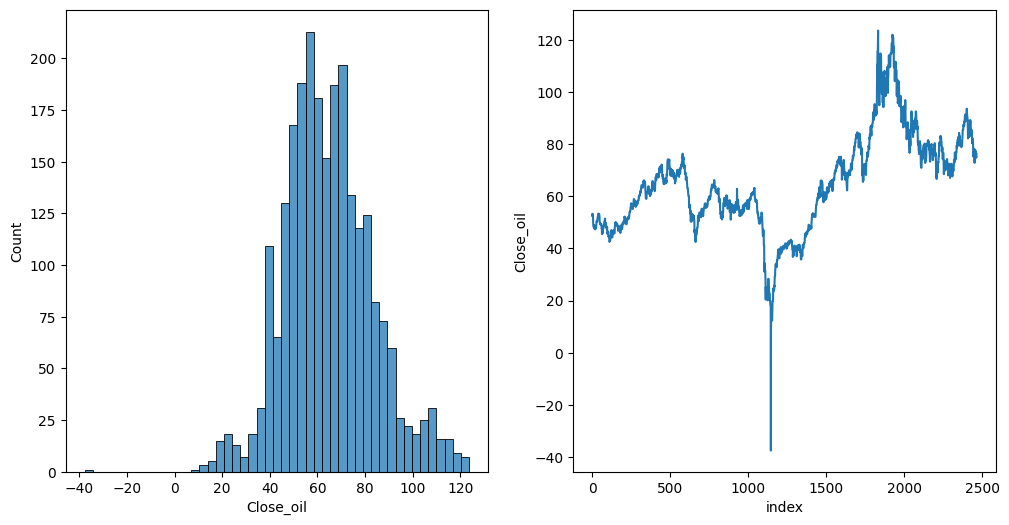

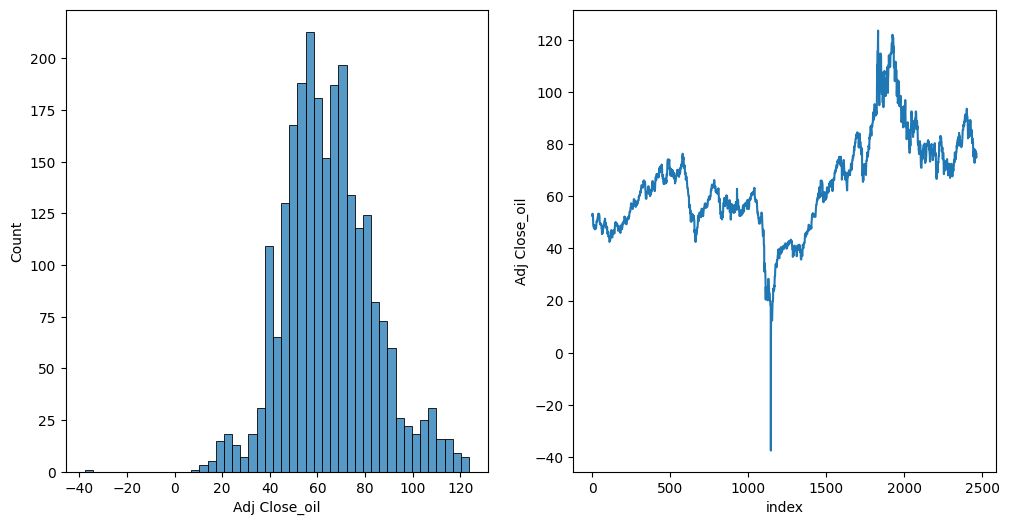

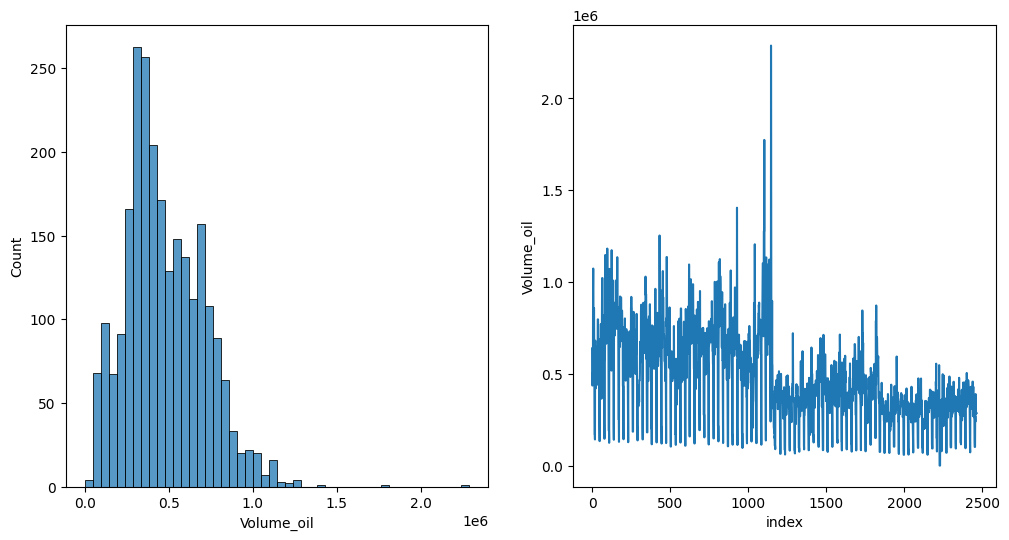

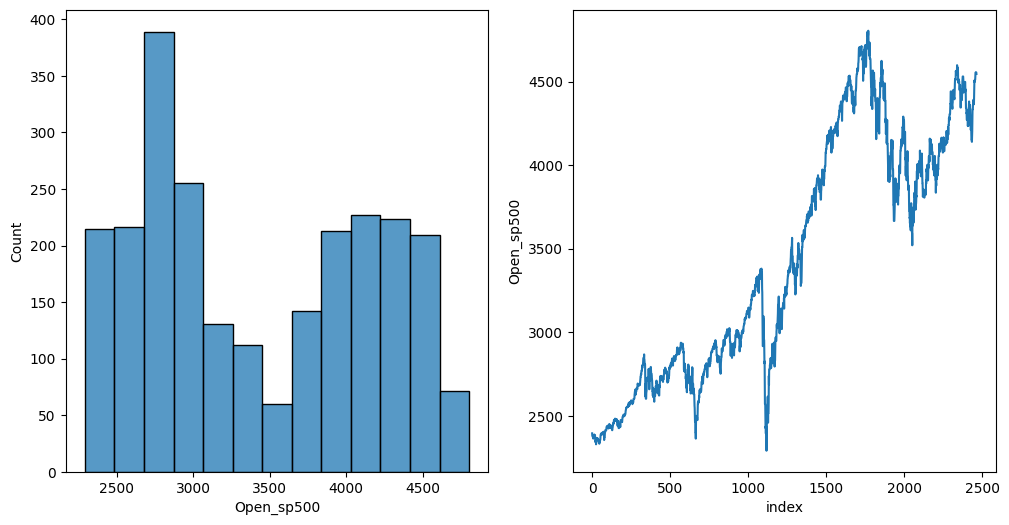

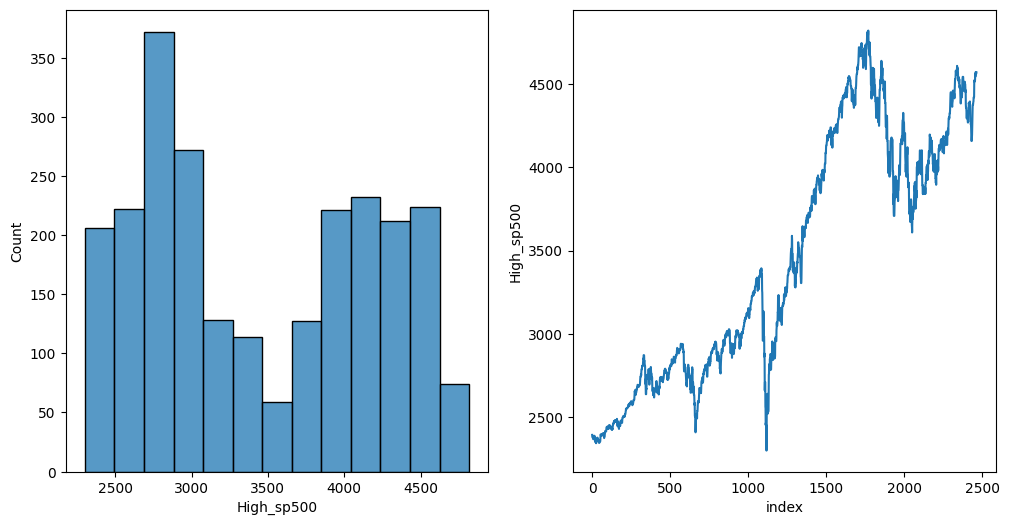

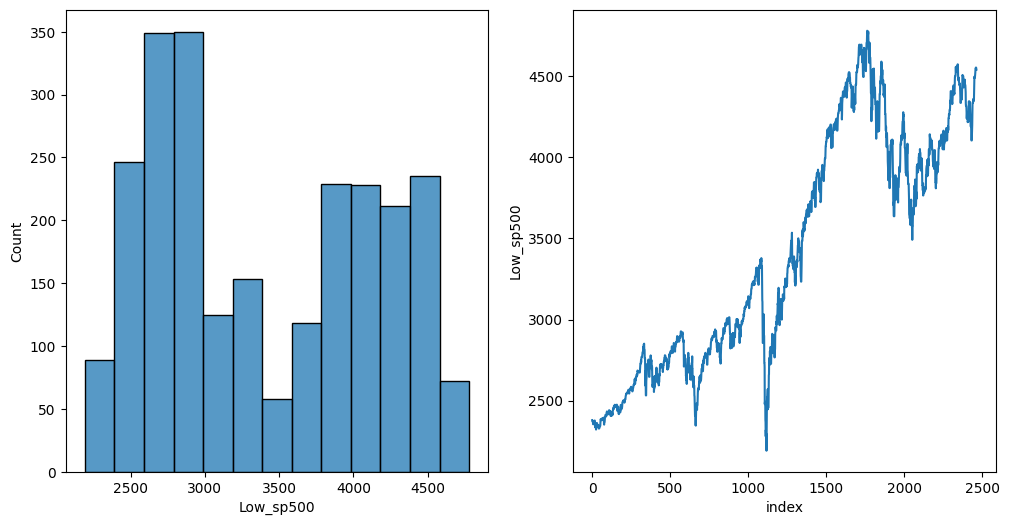

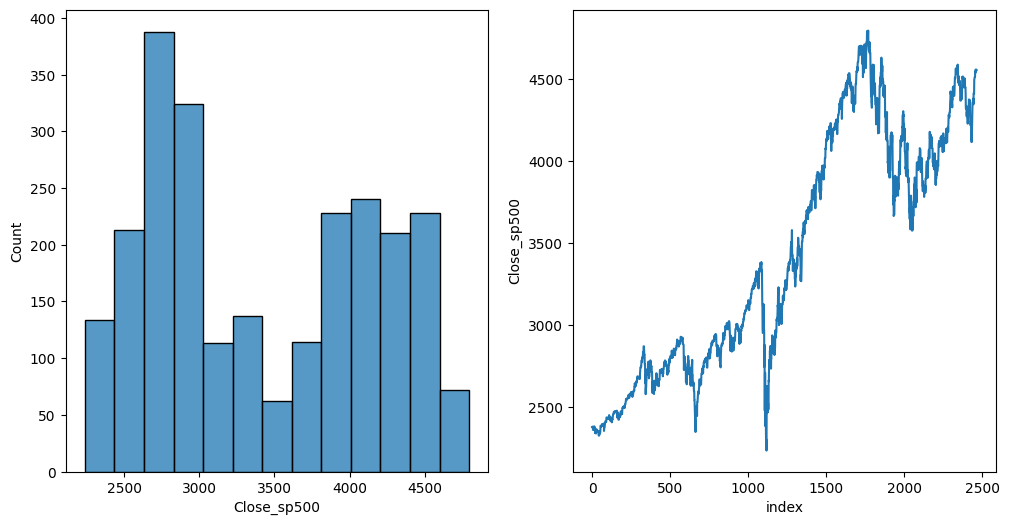

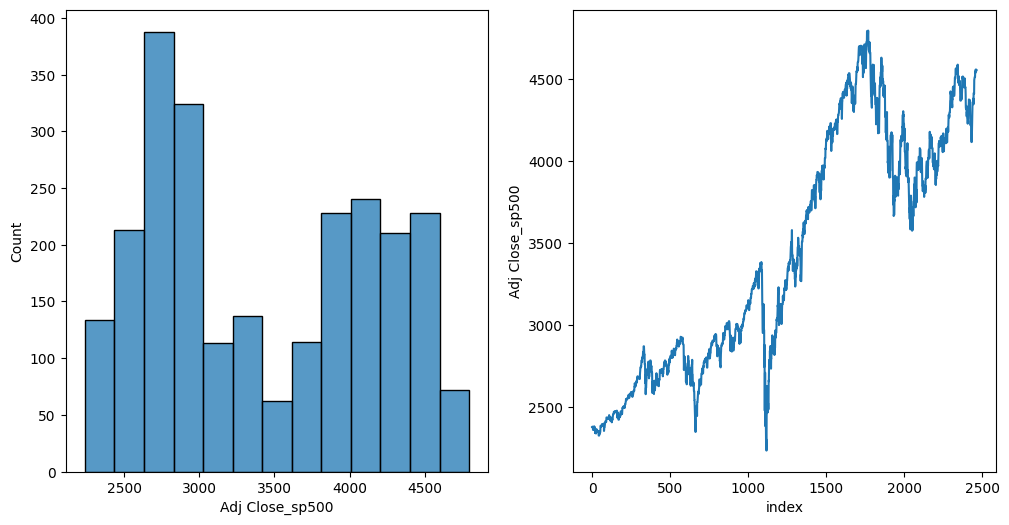

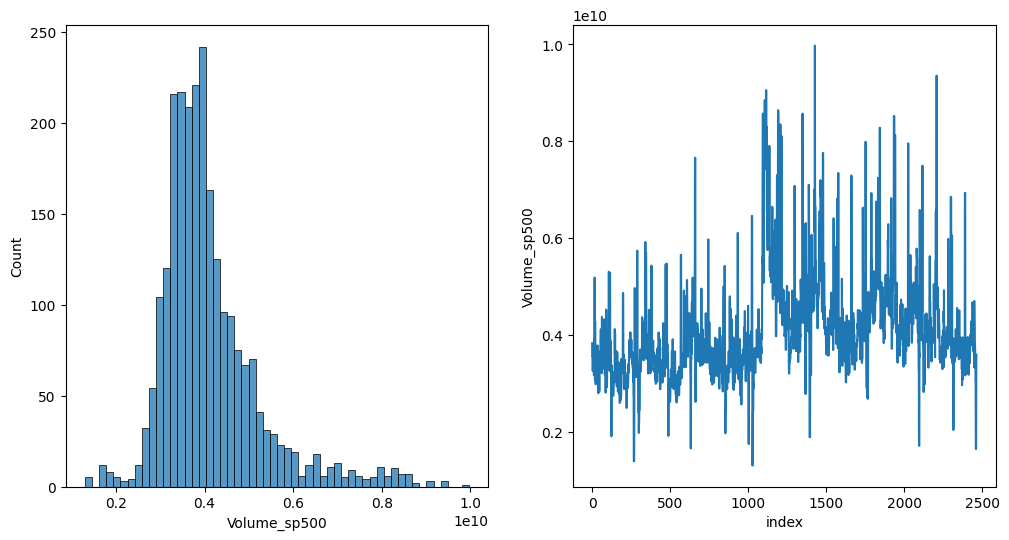

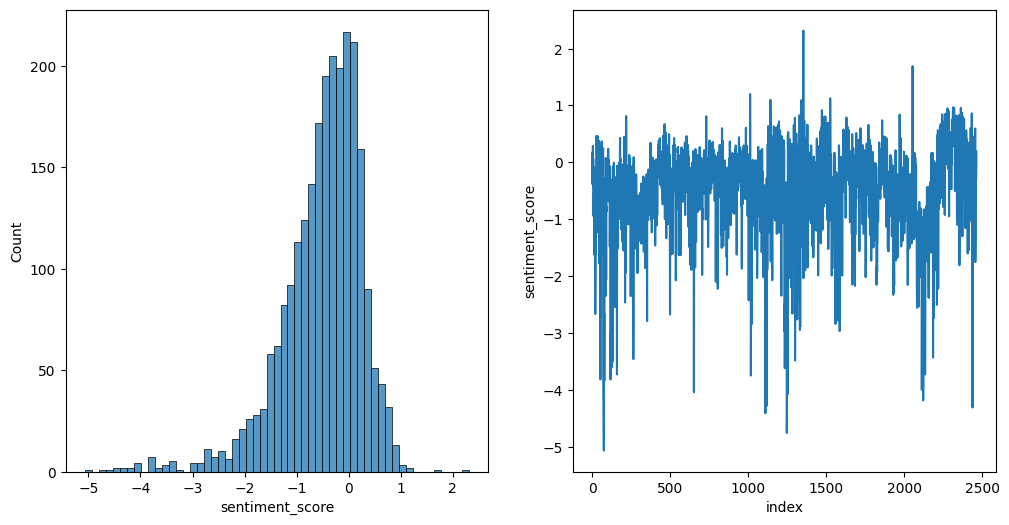

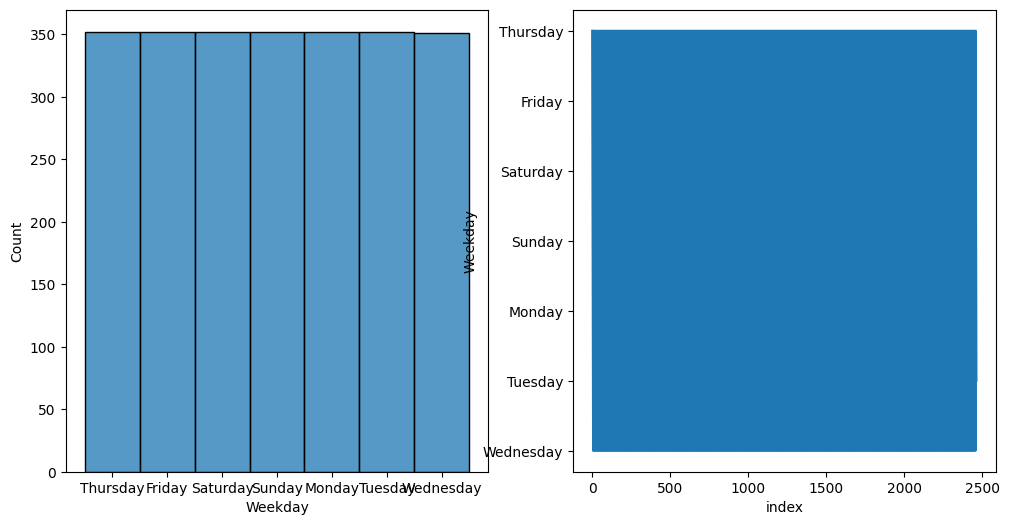

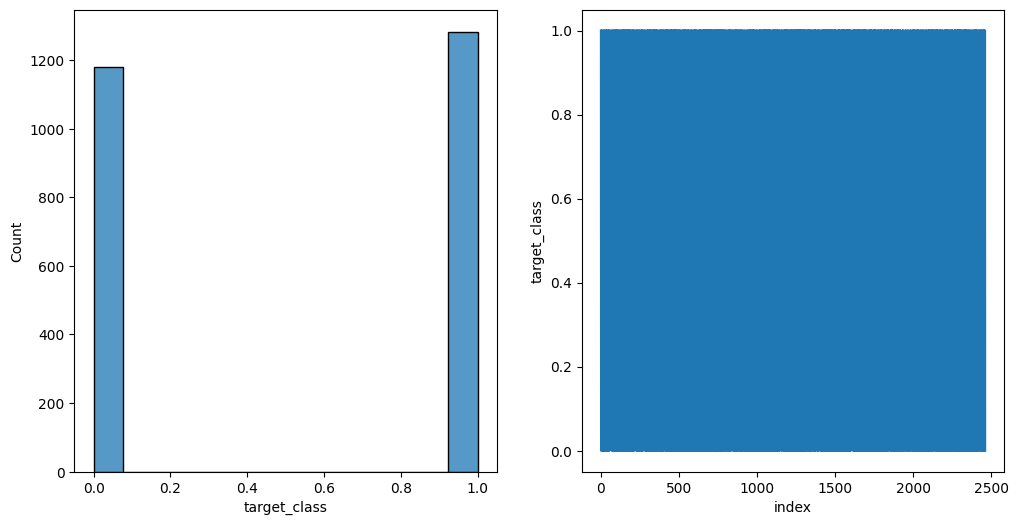

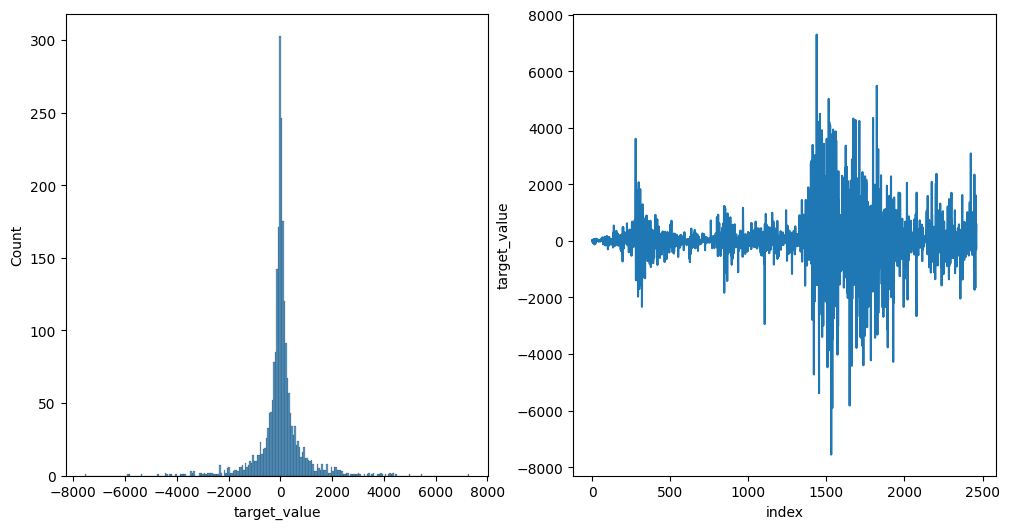

In [42]:
cols = data_aug.columns

for i in range(cols.shape[0]):
    fig, axes = plt.subplots(1,2,figsize=(12,6))
    sns.histplot(data_aug.loc[:,cols[i]],ax=axes[0])
    sns.lineplot(data_aug.loc[:,cols[i]],ax=axes[1])
    plt.show()

<Axes: xlabel='index', ylabel='Close_btc'>

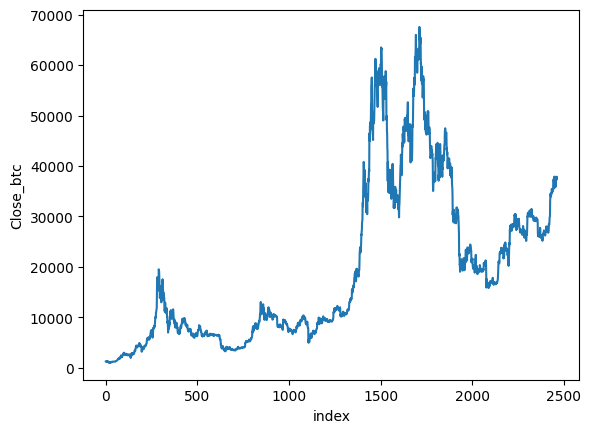

In [37]:
sns.lineplot(data_aug.Close_btc)
#sns.lineplot(data_aug.Close_oil)
#sns.lineplot(data_aug.Volume_btc)
#plt.xlim(0,400)

In [ ]:
data_aug = add_ratio_trend_features(data_aug, target,variable, window_sizes = [50])

data_aug= add_ta_features(data_aug, suffixes=['_btc', '_oil', '_gold', '_sp500'], window_sizes=[5,])

data_aug = add_custom_features(data_aug, suffixes=['_btc', '_oil', '_gold', '_sp500'])

data_aug = add_technical_indicators(data_aug, suffixes=['_btc', '_oil', '_gold', '_sp500'], rsi_periods=[5])

data_aug = data_aug.dropna()

In [ ]:
cols = data_aug.columns

In [ ]:
cols.shape

In [ ]:
# plot all distirubution to indentify vars with omassive outliers and screwed distributions

for i in range(71):
    sns.histplot(data_aug.loc[:,cols[i]])
    plt.show()

In [ ]:
log_norms = ['Open_btc','High_btc','Low_btc','Close_btc','Adj Close_btc','Volume_btc',
            'Volume_oil','Volume_gold','Volume_sp500','SMA_5_btc','WMA_5_btc','KAMA_5_btc','volatility_btc','lc_change_btc',
            'volatility_gold','volatility_sp500',]

non_scalables = ['Date','Weekday','target_class']

data_transformed = log_norm_scale(data_aug, log_norms=log_norms, non_scalables=non_scalables)

In [ ]:
for i in range(cols.shape[0]):
    sns.histplot(data_transformed.loc[:,cols[i]])
    plt.show()

In [ ]:
%run functions.py
outliers_iqr = detect_outliers(data_transformed, method='iqr', threshold=3)

In [ ]:
outliers_iqr

In [ ]:
sns.histplot(data_transformed.Close_oil)

In [ ]:
sns.lineplot(data_transformed.ROC_5_oil)
sns.lineplot(data_transformed.Close_oil)


In [ ]:
sns.lineplot(data_transformed.Close_oil)

In [ ]:
np.min(data_transformed.price_change_percent_sp500)

In [ ]:
sns.jointplot(data=data_transformed,x='sentiment_score',y='Close_btc',hue='target_class')

In [ ]:
sns.jointplot(data=data_transformed,x='price_change_percent_btc',y='price_change_percent_gold',hue='target_class')

In [ ]:
data_transformed.loc[data_transformed.price_change_percent_gold>3000]

In [ ]:
plt.plot(data_transformed.Date,data_transformed.Close_gold)

In [ ]:
numerical_data = data_aug.select_dtypes(include=['number'])

In [ ]:
sns.histplot(data_aug.loc[:,'target_value'])

In [ ]:
# Assuming 'data_aug' is your DataFrame
correlation_matrix = numerical_data.loc[numerical_data.target_class==0].corr()


plt.figure(figsize=(12, 8))  # Set the figure size
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap='coolwarm', square=True, cbar=True)

# Customize the title and labels
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Show the plot
plt.tight_layout()  # Adjust layout to make room for labels
plt.show()

In [ ]:
# Assuming 'data_aug' is your DataFrame
correlation_matrix = numerical_data.loc[numerical_data.target_class==1].corr()


plt.figure(figsize=(12, 8))  # Set the figure size
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap='coolwarm', square=True, cbar=True)

# Customize the title and labels

plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Show the plot

plt.tight_layout()  # Adjust layout to make room for labels
plt.show()

In [ ]:
plt.plot(numerical_data.sentiment_score)
plt.plot(numerical_data.target_value[100:200]/numerical_data.target_value[100:200].max())
plt.xlim(100,200)
plt.ylim(-5,1
        )

In [ ]:
np.mean(numerical_data.loc[numerical_data.target_class==0,'sentiment_score'])

In [ ]:
np.mean(numerical_data.loc[numerical_data.target_class==1,'sentiment_score'])

In [ ]:
data_

In [ ]:
np.corrcoef((data_aug.sentiment_score.values,data_aug.price_change_percent_btc.values))

In [ ]:
data_aug.loc[:,['sentiment_score','price_change_percent_btc','Close_btc']].corr()